# Diffusion maps for single-cell data analysis

Classic linear dimensionality reduction methods such as PCA are based on the restrictive assumption, that the data is lying in an affine linear subspace. In contrast to that, nonlinear dimensionality reduction methods consider general manifolds instead, see [LV07]. We will deal with diffusion maps, which is a nonlinear dimensionality reduction method, introduced by Coifman and Lafon in 2004-2006 [CL06].

## Introduction
#### Implement the diffusion maps algorithm.
Defining a class for diffusion maps and implement a fit_transform function, which returns the embedding of a given data set. This standardizes the code when comparing diffusion maps with other dimensionality reduction methods.


<img style="float:left;" src="diffusionMapAlgorithm.jpg" width=500 height=100 />




In [4]:
%matplotlib inline
import numpy as np
from scipy.io import loadmat 
from pandas import read_excel
from math import exp
from math import ceil
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [5]:
class DiffMap():
    """
    Class Diffusion Maps
    
    Parameters
    ----------
    s_comp: int, optional, default = 2
        number of dimensions in which the data will be embedded
    sigma: optional, default = 10
        bandwidth of the Gaussian kernel
    alpha: optional, default = 1
        the density rescaling parameter
    """
    
    def __init__(self, s_components = 2, sigma = 10, alpha = 1):
        self.sdim = s_components
        self.sigma = sigma
        self.alpha = alpha
        
        
    def fit_transform(self, X):
        """
        Computes the embedding
        
        Parameters
        ----------
        X: array
           input data
           
        Returns
        -------
        evecs: array [n_cells, n_comp]
            array of n_comp eigenvectors or diffusion coordinates
        """
        # your code goes here
        
        n = len(X)
        
        K = np.zeros((n,n))
        
        def kernel_exp(x, y, sigma):
            return exp(-LA.norm(x-y)**2/(2*sigma**2))
        
        Q_alpha = np.zeros((n,n))
        
        for i in range(n):
            for j in range(n):
                K[i][j]=kernel_exp(X[i],X[j], self.sigma)
                Q_alpha[i][i]+=K[i][j]
            Q_alpha[i][i] = Q_alpha[i][i]**(-self.alpha)
        
        
        K_alpha = np.matmul(np.matmul(Q_alpha, K), Q_alpha)
        
        for i in range(n):
            K_alpha[i][i]=0
            
        D_alpha_minus = np.zeros((n,n))
        
        for i in range(n):
            for j in range(n):
                D_alpha_minus[i][i]+= K_alpha[i][j]
            D_alpha_minus[i][i] = D_alpha_minus[i][i]**(-1)
            
        P = np.matmul(D_alpha_minus, K_alpha)
        
        lambdas , psi = LA.eig(P)
        psi = psi.T
        Psi=[np.dot(y,x) for y, x in sorted(zip(lambdas,psi ))]
        Psi=Psi[::-1]
        return np.array(Psi[1:(self.sdim+1)])
    
    def P(self, X):
        
        n = len(X)
        
        K = np.zeros((n,n))
        
        Q_alpha = np.zeros((n,n))
        
        for i in range(n):
            for j in range(n):
                K[i][j]=kernel_exp(X[i],X[j], self.sigma)
                Q_alpha[i][i]+=K[i][j]
            Q_alpha[i][i] = Q_alpha[i][i]**(-self.alpha)
        
        
        K_alpha = np.matmul( np.matmul( Q_alpha, K ), Q_alpha )
        
        for i in range(n):
            K_alpha[i][i]=0
            
        D_alpha_minus = np.zeros((n,n))
        
        for i in range(n):
            for j in range(n):
                D_alpha_minus[i][i]+= K_alpha[i][j]
            D_alpha_minus[i][i] = D_alpha_minus[i][i]**(-1)
            
        P = np.matmul(D_alpha_minus, K_alpha)
        
        return P

#### Perform a diffusion map analysis on the Buettner data set. 

To study the performance of diffusion maps, we start with the Buettner data set [Bue15]:
1. It contains 182 data points, which are subdivided into three different groups.Each data point has a dimension of 8989; 
2. This data set represents a matrix with the rows being the cells at different time point and the columns being the genes. In particular, the number of measured genes represents the dimension of the cell data points we want to reduce using diffusion maps; 
3. Different groups of data represent different differentiation stages of a single cell. The differentiation stages are used for labeling the cells.


In [22]:
def load_buettner_data(): 
    #load buettner data
    file = loadmat('data//data1.mat')
    data = file.get('in_X')
    data = np.array(data)

    #group assignments
    labels = file.get('true_labs')
    labels = labels[:,0] -1

    #group names
    stage_names = ['1', '2', '3']

    return data, stage_names, labels


In [23]:
# your code goes here
data, tage_names, labels=load_buettner_data()
#labels=np.array(labels)
diffusion_map=DiffMap(3,20,1)
Y=diffusion_map.fit_transform(data)
Y.shape

(3, 182)

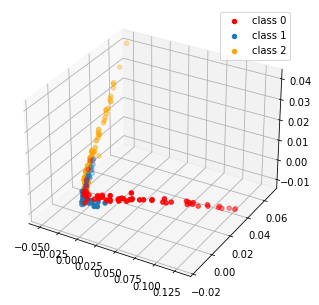

In [6]:
def plot3d(Y, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(Y[0][labels==0], Y[1][labels==0], Y[2][labels==0], c = "red", label = "class 0")
    ax.scatter(Y[0][labels==1], Y[1][labels==1], Y[2][labels==1], label = "class 1")
    ax.scatter(Y[0][labels==2], Y[1][labels==2], Y[2][labels==2], c = "orange", label = "class 2")

    plt.legend()

plot3d(Y, labels)

#### Perform a PCA analysis of the Buettner data set.

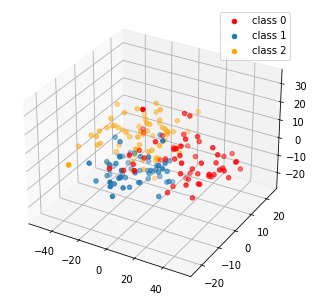

In [7]:
pca=PCA(n_components=3)
plot3d(pca.fit_transform(data).T, labels)

## Single-cell data analysis

In the following, we will apply diffusion maps to the Guo data [Guo10]. Similarly, you will find some necessary information:

1. the input data, which is a matrix with a certain number of cells as row number and a certain number of genes as column number
2. the names of the measured genes and
3. an assignment of each cell to an embryonic stage. These assignments have to be converted into numerical labels to use them for the scatter plots.

Take a look at the file guo.xlsx. The naming annotation in the first column refers to the embryonic stage, embryo number, and individual cell number, thus 64C 2.7 refers to the 7th cell harvested from the 2nd embryo collected from the 64-cell stage. In the first row, you will find the names of the measured genes.

In [11]:
read_excel('data//guo.xlsx')

,Cell,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
0,1C 1,14.01,19.28,23.89,28.00,28.0,21.28,20.84,28.00,23.08,...,18.24,13.94,23.84,16.33,22.54,22.82,16.26,28.0,28.0,18.53
1,1C 2,13.68,18.56,28.00,28.00,28.0,23.43,20.93,28.00,23.05,...,17.77,13.54,25.00,16.13,20.66,26.33,16.14,28.0,28.0,18.29
2,1C 3,13.42,18.19,26.18,28.00,28.0,22.87,19.61,28.00,21.73,...,17.51,13.50,28.00,15.90,20.32,22.93,15.47,28.0,28.0,18.92
3,1C 4,13.69,18.59,28.00,28.00,28.0,23.28,20.72,28.00,22.92,...,16.52,13.22,28.00,16.16,28.00,28.00,15.85,28.0,28.0,19.25
4,1C 5,13.47,18.60,24.20,28.00,28.0,24.19,21.75,23.69,22.41,...,17.82,13.41,24.26,16.15,20.15,24.32,16.05,28.0,28.0,18.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,64C 7.10,13.32,23.22,19.76,22.13,28.0,19.84,23.52,21.75,19.14,...,28.00,19.62,21.80,28.00,22.14,20.14,19.43,28.0,28.0,18.13
438,64C 7.11,12.60,23.35,18.01,21.64,28.0,20.07,28.00,22.53,18.72,...,24.72,20.11,24.57,28.00,22.28,20.69,20.29,28.0,28.0,18.03
439,64C 7.12,12.75,22.73,20.27,28.00,28.0,19.47,28.00,19.83,19.17,...,23.71,19.02,22.15,28.00,21.42,20.97,18.62,28.0,28.0,17.73
440,64C 7.13,13.66,25.26,20.39,22.19,28.0,21.02,28.00,28.00,18.98,...,27.59,21.32,25.15,28.00,23.22,20.85,20.67,28.0,28.0,18.87


In [48]:
def load_guo_data():
    #load guo data
    data_frame = read_excel('data//guo.xlsx', sheet_name = 'Sheet1')
   
    #data
    adata = data_frame.to_numpy()
    data = adata[:,1:]
    embryonic_stages =adata[:,0]
    
    #genes
    genes_tmp = data_frame.axes[1][1:]
    genes_names = [genes_tmp[k] for k in range(genes_tmp.size)]

    #stage_names and creating labels
    stage_names = ['2C', '4C', '8C', '16C', '32C', '64C']
    
    #labels = np.array([next(np.where([name.startswith(sname) for name in stage_names])[0][0] for sname in stage_names if ename.startswith(sname)) for ename in embryonic_stages])
    labels = np.array([np.where([x.startswith(e) for x in embryonic_stages])[0][0] for e in stage_names])
    
    return data, stage_names, genes_names, labels

### Pre-processing (data cleaning and normalization)

For the Guo data, we know the following information:
1. cells from the 1-cell stage embryos were treated differently in the experimental procedure and
2. entries bigger than the baseline 28 point out undetectable data

Thus, cells from the 1-cell stage and cells with at least one entry bigger than the baseline have to be excluded from analysis:

$\mathcal{X} = \mathcal{X}_{raw}\,\backslash\, \left(\mathcal{X}_{1C}\,\cup\, \left\{\mathbf{x}\in \mathcal{X}_{raw}\,|\,\exists j \in \{1,...,G\}\,s.t.\,\mathbf{x}_j>28\right\} \right)$ 

where the raw data $\mathcal{X}_{raw}=\{\mathbf{x}_1,...,\mathbf{x}_n\}\subset \mathbb{R}^G$ and $\mathcal{X}_{1C}$ denotes the set of cells from the 1-cell stage.

In [49]:
#delete 1C
data_new=data[labels[0]:].T 

In [50]:
delete_from_data=np.array([0])
for i in range(len(data_new)):
    for num in data_new[i]:
        if num>28:
            delete_from_data=np.concatenate((delete_from_data,[i]))
delete_from_data

array([ 0,  7, 23, 29, 30, 38, 42])

In [51]:
#delete greater than 28
indices=np.delete(range(len(data_new)),delete_from_data[1:]) 
data_new=np.array([data_new[i] for i in indices ]).T
data_new

array([[15.64, 28.0, 23.4, ..., 28.0, 28.0, 19.31],
       [16.08, 23.68, 28.0, ..., 28.0, 23.7, 20.99],
       [15.84, 24.16, 20.14, ..., 28.0, 28.0, 21.15],
       ...,
       [12.75, 22.73, 20.27, ..., 28.0, 28.0, 17.73],
       [13.66, 25.26, 20.39, ..., 28.0, 28.0, 18.87],
       [13.78, 25.46, 20.79, ..., 28.0, 28.0, 18.47]], dtype=object)

Afterwards, we need to normalize the data, in order to obtain more
accurate results. A common strategy in biology is the normalization
via reference genes. In our case, we subtract for each cell the mean
expression of the endogenous control genes Actb and Gapdh apart
from the ones with baseline value 28:

$\mathbf{x}_{ij}\leftarrow \mathbf{x}_{ij}-\frac{1}{2}(\mathbf{x}_{ig_{Actb}}+\mathbf{x}_{ig_{Gapdh}})$

In [33]:
ACTB=np.where([x=='Actb'for x in genes_names])[0][0]
GAPDH=np.where([x=='Gapdh'for x in genes_names])[0][0]

In [16]:
#Actb=0 Gapdh=15
m=round(data_new[0][0]-(data_new[0][ACTB]+data_new[0][GAPDH])/2,3)
for x in data_new:
    for i in range(len(x)):
        if x[i]<28:
            x[i]=round(x[i]-(x[ACTB]+x[GAPDH])/2,3)
            if x[i]>m:
                m=x[i]

for x in data_new:
    for i in range(len(x)):
        if x[i]==28:
            x[i]=ceil(m)
data_new.shape

(433, 42)

#### Perform a diffusion map analysis of the pre-processed Guo data.

In [17]:
# your code goes here
diffusion_map=DiffMap(2,10,1)
Psi=diffusion_map.fit_transform(data_new)
Psi.shape

(2, 433)

In [18]:
l=np.concatenate(([x-labels[0] for x in labels],[len(data_new)]))
l

array([  0,  19,  42,  86, 161, 274, 433])

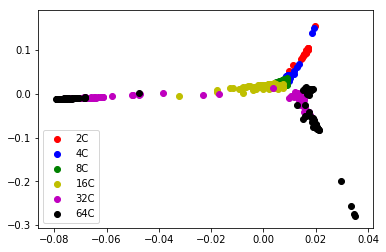

In [19]:
# your code goes here
for c,i in [('r',0),('b',1),('g',2),('y',3),('m',4),('k',5)]:
    xs=Psi[0][l[i]:l[i+1]]
    ys=Psi[1][l[i]:l[i+1]]
    plt.scatter(xs, ys, c=c,label=stage_names[i])

plt.legend()
plt.show()

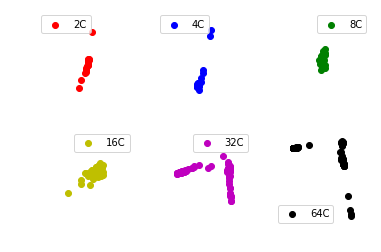

In [20]:
#easier observation of the data

for c,i in [('r',0),('b',1),('g',2),('y',3),('m',4),('k',5)]:
    xs=Psi[0][l[i]:l[i+1]]
    ys=Psi[1][l[i]:l[i+1]] 
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.scatter(xs, ys, c=c,label=stage_names[i])
    plt.legend()

plt.show()

#### Task 6: Comparison with the un-pre-processed data.

In [21]:
# your code goes here
data_new2= data.T
delete_from_data=np.array([0])
for i in range(len(data_new2)):
    for num in data_new2[i]:
        if num>28:
            delete_from_data=np.concatenate((delete_from_data,[i]))

indices=np.delete(range(len(data_new2)),delete_from_data[1:]) #delete greater than 28
data_new2=np.array([data_new2[i] for i in indices ]).T

In [22]:
diffusion_map=DiffMap(2,10,1)
Psi=diffusion_map.fit_transform(data_new2)

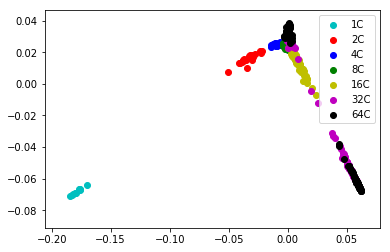

In [23]:
l=[0,9,28,51,95,170,283,442]
stage_names2=np.concatenate((['1C'],stage_names))
for c,i in [('c',0),('r',1),('b',2),('g',3),('y',4),('m',5),('k',6)]:
    xs=Psi[0][l[i]:l[i+1]]
    ys=Psi[1][l[i]:l[i+1]]
    plt.scatter(xs, ys, c=c,label=stage_names2[i])

plt.legend()
plt.show()

### Comparison with other dimensionality reduction methods

#### Task 7: Compare diffusion maps with two other methods.

In [24]:
#PCA
pca = PCA(n_components=2)
pca.fit(data_new)
data_PCA=pca.transform(data_new).T
data_PCA.shape

(2, 433)

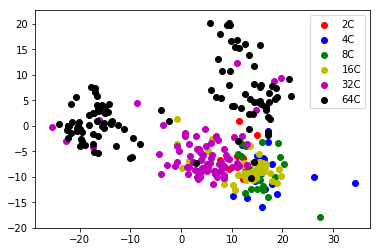

In [25]:
for c,i in [('r',0),('b',1),('g',2),('y',3),('m',4),('k',5)]:
    xs=data_PCA[0][l[i]:l[i+1]]
    ys=data_PCA[1][l[i]:l[i+1]]
    plt.scatter(xs, ys, c=c,label=stage_names[i])

plt.legend()
plt.show()

In [26]:
# your code goes here
data_TSNE = TSNE(n_components=2).fit_transform(data_new).T
data_TSNE.shape

(2, 433)

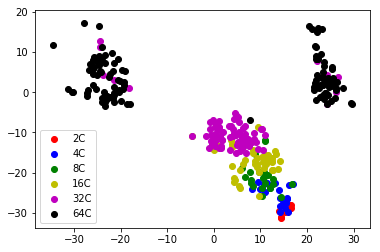

In [27]:
for c,i in [('r',0),('b',1),('g',2),('y',3),('m',4),('k',5)]:
    xs=data_TSNE[0][l[i]:l[i+1]]
    ys=data_TSNE[1][l[i]:l[i+1]]
    plt.scatter(xs, ys, c=c,label=stage_names[i])
    
plt.legend()
plt.show()

### Parameter selection

#### Task 8: Bandwidth comparison.

In [28]:
# your code goes here
def different_parameters(sigma):
    diffusion_map=DiffMap(2,sigma,1)
    Psi=diffusion_map.fit_transform(data_new)
    for c,i in [('r',0),('b',1),('g',2),('y',3),('m',4),('k',5)]:
        xs=Psi[0][l[i]:l[i+1]]
        ys=Psi[1][l[i]:l[i+1]]
        plt.scatter(xs, ys, c=c,label=stage_names[i])
    plt.title("Sigma = {}".format(sigma))
    plt.legend()
    plt.show()

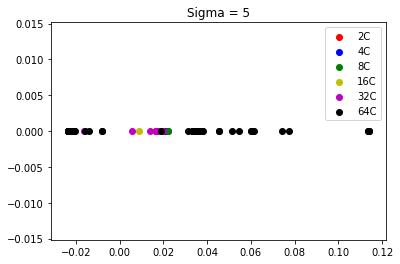

In [62]:
different_parameters(5)

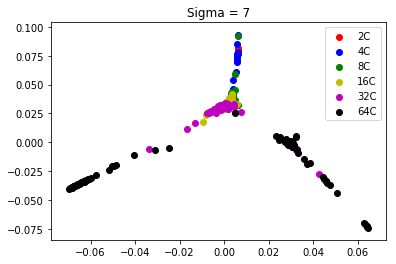

In [29]:
different_parameters(7)

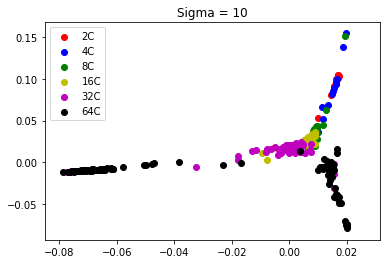

In [30]:
different_parameters(10)

In [ ]:
different_parameters(20)

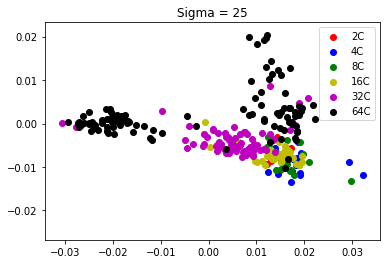

In [66]:
different_parameters(25)

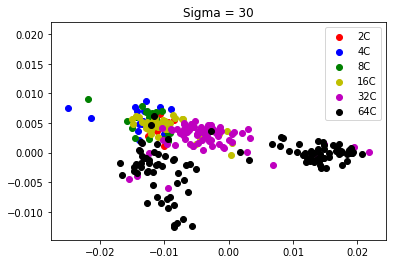

In [67]:
different_parameters(30)

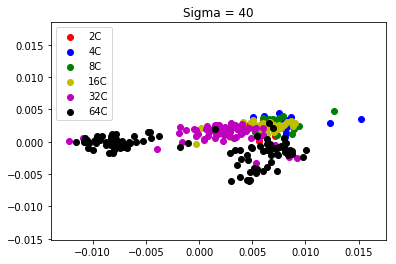

In [68]:
different_parameters(40)

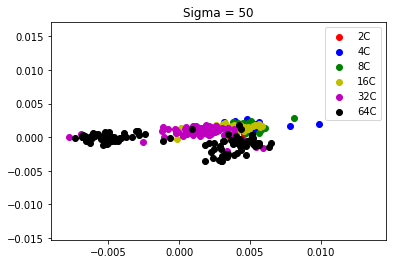

In [69]:
different_parameters(50)

#### Task 9: Implement the rule for $\sigma$ and plot the embedding with the $\sigma$ chosen by this rule.

In [70]:
# your code goes here
def min_diff(X,i):
    return min([LA.norm(X[i]-X[j])**2 for j in np.delete(range(len(X)),i)])
def sigma_Lafon(X):
    s=0
    for i in range(len(X)):
        s+=min_diff(X,i)
        
    return (s/(2*len(X)))**(1/2)


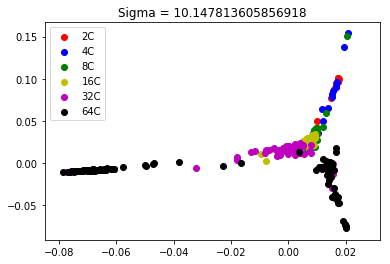

In [71]:
# your code goes here
different_parameters(sigma_Lafon(data_new))

### Cell group detection

Now, we want to apply spectral clustering to detect cell groups in the single-cell data.

#### Task 10: Implement the spectral clustering algorithm using k-means with $\Lambda$ as input.

In [72]:
# your code goes here
from sklearn.cluster import KMeans
def spectral_clustering(data, Lambda):
    diffusion_map=DiffMap(Lambda - 1,10,1)
    Psi = diffusion_map.fit_transform(data)    
    kmeans = KMeans(n_clusters= Lambda - 1, random_state=0).fit(data)
    labels=kmeans.labels_
    return labels, Psi



#### Task 11: Plot the first 20 eigenvalues of transition matrix $P$ for the Guo data and identify $\Lambda$.

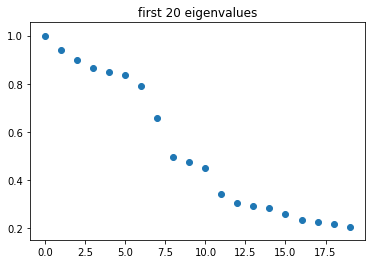

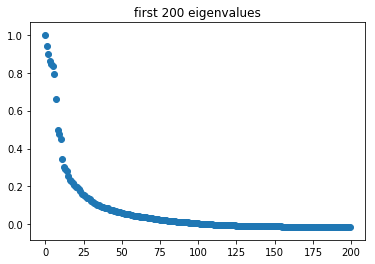

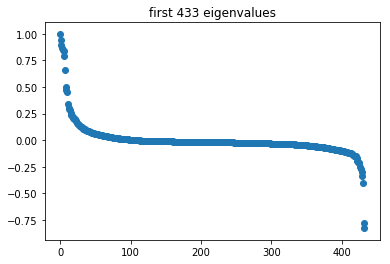

In [73]:
# your code goes here
# plot the first 20 eigenvalues
diffusion_map=DiffMap(2,10,1)
P=diffusion_map.P(data_new)
lambdas , psi = LA.eig(P)
lambdas = sorted(lambdas, reverse = True)

def first_n(n):
    xs=range(n)
    ys=lambdas[:n]
    plt.scatter(xs, ys)
    plt.title("first {} eigenvalues".format(n))
    plt.show()

first_n(20)
first_n(200)
first_n(433)


In [74]:
#determine the biggest gap 
gaps=[lambdas[i] - lambdas[i+1] for i in range(432)]
Lambda = 1 
gap = lambdas[0] - lambdas [1]
for i in range(1, 19):
    if lambdas[i] - lambdas[i+1] >= gap:
        gap = lambdas[i] - lambdas[i+1]
        Lambda = i+1

print("Lambda determined by the biggest gap among first 20 eigenvalues:\n{}".format(Lambda))    

Lambda determined by the biggest gap among first 20 eigenvalues:
8


#### Task 12: Perform the spectral clustering algorithm for the Guo data.

In [75]:
# your code goes here
labels, Psi = spectral_clustering(data_new, Lambda)
labels

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 1, 3, 4, 3, 3, 4, 4, 3, 4, 4, 5, 3, 3, 5, 3, 4,
       4, 5, 4, 4, 4, 4, 3, 3, 3, 4, 4, 3, 2, 4, 3, 3, 4, 3, 4, 4, 4, 4,
       3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 4, 5, 5, 4, 3, 3, 3, 4, 3, 3, 4, 4,
       5, 3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 4, 3, 2, 3, 3, 4, 3, 4, 3, 4, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 3,
       4, 4, 4, 3, 3, 3, 3, 2, 4, 3, 5, 3, 0, 5, 5, 0, 5, 3, 5, 3, 5, 3,
       5, 3, 3, 3, 3, 3, 3, 3, 5, 0, 0, 3, 3, 5, 3,

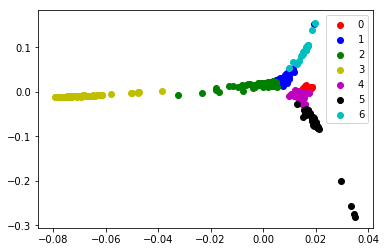

In [76]:
for color,i in [('r',0),('b',1),('g',2),('y',3),('m',4),('k',5),('c',6)]:
    plt.scatter(Psi[0][labels==i],Psi[1][labels==i],c=color,label=i)

plt.legend()
plt.show()

### Reference

[Bue15]  F. Buettner et al. “Computational analysis of cell-to-cell heterogeneity in single-cell RNA-sequencing data reveals hidden subpopulations of cells.” In: *Applied and Computational Harmonic Analysis 33 (2015)*, pp. 155–160.

[Guo10]  G. Guo et al. “Resolution of cell fate decisions revealed by singlecell gene expression analysis from zygote to blastocyst.” In: *Developmental Cell* 18 (2010), pp. 675–685. doi: 10.1016/j.devcel.
2010.02.012.

[CL06]  R.R. Coifman and S. Lafon. “Diffusion Maps.” In: *Applied and Computational Harmonic Analysis* 7 (2006), pp. 5–30. doi: 10.1016/j.acha.2006.04.006.

[LV07]  J.A. Lee and M. Verleysen. *Nonlinear dimensionality reduction*. Springer Science & Business Media, 2007